## Step 1: Import Packages
Modify the system path and load the corresponding packages and functions 

In [15]:
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
ROOT = os.path.dirname(os.path.abspath("."))
sys.path.append(ROOT)
import torch
import argparse
import os.path as osp
from mmcv import Config
from trademaster.utils import replace_cfg_vals
from trademaster.nets.builder import build_net
from trademaster.environments.builder import build_environment
from trademaster.datasets.builder import build_dataset
from trademaster.agents.builder import build_agent
from trademaster.optimizers.builder import build_optimizer
from trademaster.losses.builder import build_loss
from trademaster.trainers.builder import build_trainer
from trademaster.transition.builder import build_transition
from trademaster.utils import plot

## Step 2: Load Configs
Load default config from the folder `configs/portfolio_management/portfolio_management_dj30_eiie_eiie_adam_mse.py`

In [16]:
parser = argparse.ArgumentParser(description='Download Alpaca Datasets')
parser.add_argument("--config", default=osp.join(ROOT, "configs", "portfolio_management", "portfolio_management_dj30_eiie_eiie_adam_mse.py"),
                    help="download datasets config file path")
parser.add_argument("--task_name", type=str, default="train")

args, _= parser.parse_known_args()
cfg = Config.fromfile(args.config)
task_name = args.task_name
cfg = replace_cfg_vals(cfg)

In [17]:
cfg

Config (path: E:\workspace\RA\TradeMaster\configs\portfolio_management\portfolio_management_dj30_eiie_eiie_adam_mse.py): {'data': {'type': 'PortfolioManagementDataset', 'data_path': 'data/portfolio_management/dj30', 'train_path': 'data/portfolio_management/dj30/train.csv', 'valid_path': 'data/portfolio_management/dj30/valid.csv', 'test_path': 'data/portfolio_management/dj30/test.csv', 'tech_indicator_list': ['zopen', 'zhigh', 'zlow', 'zadjcp', 'zclose', 'zd_5', 'zd_10', 'zd_15', 'zd_20', 'zd_25', 'zd_30'], 'length_day': 10, 'initial_amount': 100000, 'transaction_cost_pct': 0.001, 'test_dynamic_path': 'data/portfolio_management/dj30/DJI_label_by_DJIindex_3_24_-0.25_0.25.csv'}, 'environment': {'type': 'PortfolioManagementEIIEEnvironment'}, 'agent': {'type': 'PortfolioManagementEIIE', 'memory_capacity': 1000, 'gamma': 0.99, 'policy_update_frequency': 500}, 'trainer': {'type': 'PortfolioManagementEIIETrainer', 'epochs': 10, 'work_dir': 'work_dir/portfolio_management_dj30_eiie_eiie_adam_mse

## Step 3: Build Dataset
Build datasets from cfg defined above

In [18]:
dataset = build_dataset(cfg)

## Step 4: Build Reinforcement Learning Environments
Build environments based on cfg and previously-defined dataset

A style-test is provided as an option to test the algorithm's performance under different market conditions

In [19]:
train_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="train"))
valid_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="valid"))
test_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="test"))

In [20]:
train_environment.df.head()

,date,open,high,low,close,adjcp,tic,zopen,zhigh,zlow,zadjcp,zclose,zd_5,zd_10,zd_15,zd_20,zd_25,zd_30
0,2012-01-04,14.642857,14.810000,14.617143,14.765714,12.643501,AAPL,-0.008320,0.002999,-0.010062,-0.143726,0.005374,-0.010348,-0.011415,0.002751,-0.061124,-0.072128,-0.126481
0,2012-01-04,64.099998,64.129997,63.400002,63.759998,49.393219,AMGN,0.005332,0.005803,-0.005646,-0.225326,-0.005459,0.007794,-0.008521,-0.008222,-0.017393,-0.031253,-0.042012
0,2012-01-04,48.020000,48.380001,47.400002,48.240002,41.672607,AXP,-0.004561,0.002902,-0.017413,-0.136140,-0.003100,0.004561,-0.004885,-0.017185,-0.029824,-0.045096,-0.052918
0,2012-01-04,74.099998,74.599998,73.589996,74.330002,60.821106,BA,-0.003094,0.003632,-0.009956,-0.181742,0.001482,0.002922,-0.007421,-0.004776,-0.002812,-0.013054,-0.001687
0,2012-01-04,93.410004,95.510002,93.410004,94.849998,70.945084,CAT,-0.015182,0.006958,-0.015182,-0.252029,0.009257,0.010322,-0.004803,-0.010627,-0.001714,-0.005438,0.006133


In [21]:
valid_environment.df.head()

,date,open,high,low,close,adjcp,tic,zopen,zhigh,zlow,zadjcp,zclose,zd_5,zd_10,zd_15,zd_20,zd_25,zd_30
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.894325,AAPL,-0.013684,0.000832,-0.017180,-0.015890,0.022816,-0.024318,-0.043549,-0.056578,-0.070455,-0.080170,-0.087020
0,2020-01-02,243.000000,243.190002,238.979996,240.100006,224.704163,AMGN,0.012078,0.012870,-0.004665,-0.064123,-0.004024,0.003640,0.006693,0.002318,-0.005087,-0.009168,-0.015607
0,2020-01-02,124.660004,126.269997,124.230003,125.849998,121.988235,AXP,-0.009456,0.003337,-0.012872,-0.030685,0.010925,-0.009114,-0.010370,-0.014727,-0.024206,-0.031199,-0.034886
0,2020-01-02,328.549988,333.350006,327.700012,333.320007,331.348572,BA,-0.014311,0.000090,-0.016861,-0.005915,0.023207,-0.012636,-0.007479,0.000086,0.012233,0.027589,0.041214
0,2020-01-02,149.000000,150.550003,147.979996,150.529999,141.766678,CAT,-0.010164,0.000133,-0.016940,-0.058216,0.019299,-0.013844,-0.018189,-0.023025,-0.031572,-0.034058,-0.035975


In [22]:
test_environment.df.head()

,date,open,high,low,close,adjcp,tic,zopen,zhigh,zlow,zadjcp,zclose,zd_5,zd_10,zd_15,zd_20,zd_25,zd_30
0,2021-01-04,133.520004,133.610001,126.760002,129.410004,128.453430,AAPL,0.031760,0.032455,-0.020478,-0.007392,-0.024719,0.031420,0.017758,0.002323,-0.010486,-0.021578,-0.034987
0,2021-01-04,231.250000,231.250000,223.669998,226.660004,217.989258,AMGN,0.020251,0.020251,-0.013192,-0.038254,-0.014179,0.000856,-0.004266,0.001206,0.002958,0.000972,-0.002494
0,2021-01-04,121.300003,121.800003,116.849998,118.040001,116.058220,AXP,0.027618,0.031854,-0.010081,-0.016789,-0.023737,0.007930,-0.002330,0.000971,0.011670,0.014202,0.010022
0,2021-01-04,210.000000,210.199997,202.490005,202.720001,202.720001,BA,0.035912,0.036898,-0.001135,0.000000,-0.052976,0.051490,0.065741,0.083935,0.102499,0.099298,0.089213
0,2021-01-04,183.000000,185.979996,180.250000,182.149994,176.713684,CAT,0.004667,0.021027,-0.010431,-0.029845,0.000714,-0.012649,-0.014598,-0.014490,-0.014181,-0.020199,-0.024026


## Step 5: Build Net 
Update information about the state and action dimension in the config and create nets and optimizer for EIIE


In [23]:
action_dim = train_environment.action_dim # 29
state_dim = train_environment.state_dim # 11
input_dim = len(train_environment.tech_indicator_list)
time_steps = train_environment.time_steps

cfg.act.update(dict(input_dim=input_dim, time_steps=time_steps))
cfg.cri.update(dict(input_dim=input_dim, action_dim= action_dim, time_steps=time_steps))

act = build_net(cfg.act)
cri = build_net(cfg.cri)
act_optimizer = build_optimizer(cfg, default_args=dict(params=act.parameters()))
cri_optimizer = build_optimizer(cfg, default_args=dict(params=cri.parameters()))

## Step 6: Build Loss
Build loss from config

In [24]:
criterion = build_loss(cfg)

## Step 7: Build Transition
Build transition from config

In [25]:
transition = build_transition(cfg)


## Step 8: Build Agent
Build agent from config and detect device

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent = build_agent(cfg, default_args=dict(action_dim=action_dim,state_dim=state_dim,time_steps = time_steps,act=act,cri=cri,act_optimizer=act_optimizer,cri_optimizer = cri_optimizer,criterion=criterion,transition = transition,device = device))

## Step 9: Build Trainer
Build trainer from config and create work directionary to save the result, model and config

In [28]:
trainer = build_trainer(cfg, default_args=dict(train_environment=train_environment,valid_environment=valid_environment,test_environment=test_environment,agent=agent,device=device))
work_dir = os.path.join(ROOT, cfg.trainer.work_dir)

if not os.path.exists(work_dir):
    os.makedirs(work_dir)
cfg.dump(osp.join(work_dir, osp.basename(args.config)))

| Arguments Keep work_dir: E:\workspace\RA\TradeMaster\work_dir/portfolio_management_dj30_eiie_eiie_adam_mse


## Step 10: Train the Trainer
Train the trainer based on the config and get results from workdir

In [29]:
trainer.train_and_valid()

Train Episode: [1/10]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| 180.538517%  |  84.592018  | 0.757197%  |  15.048310%  |
+--------------+-------------+------------+--------------+
Valid Episode: [1/10]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  9.570612%   |   4.540308  | 2.142199%  |  31.100391%  |
+--------------+-------------+------------+--------------+
Train Episode: [2/10]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| 180.546097%  |  84.594732  | 0.757204%  |  15.048266%  |
+--------------+-------------+------------+--------------+
Valid Episode: [2/10]
+--------------+-----------

In [30]:
trainer.test()

Resume checkpoint E:\workspace\RA\TradeMaster\work_dir/portfolio_management_dj30_eiie_eiie_adam_mse\checkpoints\best.pth
Test Best Episode
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  14.617324%  |  20.697943  | 0.719180%  |  6.740932%   |
+--------------+-------------+------------+--------------+


array([ 0.00000000e+00,  2.79307864e-03,  8.03235722e-03, -3.93809069e-04,
       -7.13566242e-03, -8.14274141e-04,  1.60016523e-04, -1.77175544e-02,
        9.15854289e-03, -1.90938578e-02,  6.05741047e-03,  1.32627770e-02,
        1.01153230e-03,  1.16507352e-02,  4.71529342e-03,  7.33856503e-03,
       -9.77104404e-04,  5.85172654e-04, -7.16182035e-06,  1.49281178e-03,
        8.19229606e-04,  4.16264979e-03, -6.54780099e-03, -8.86493845e-04,
        2.40050355e-04,  1.36838120e-04,  1.06449953e-02, -1.54122393e-02,
       -1.48947502e-02,  1.76103594e-02, -5.31748966e-03, -4.05890861e-03,
       -1.02564200e-02,  1.85990659e-02,  8.44538536e-03,  1.76600645e-03,
        1.44480053e-02,  4.27544712e-03,  7.32522456e-03,  6.87199206e-03,
       -2.66940633e-03,  3.45965908e-03, -7.61248812e-03, -5.77343675e-03,
        5.02211048e-03, -7.06976797e-03, -1.05412416e-03,  5.75415668e-03,
        1.51537217e-02,  3.80512916e-03, -4.60344688e-03, -1.51846979e-03,
        4.46925664e-03,  

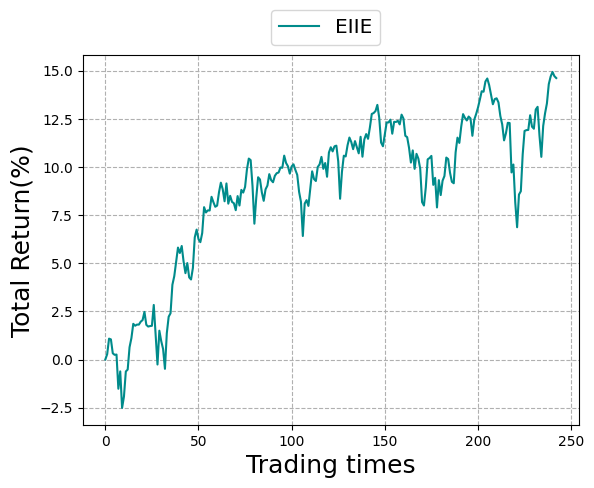

In [31]:
plot(trainer.test_environment.save_asset_memory(),alg="EIIE")

In [32]:
df=trainer.test_environment.save_asset_memory()

In [33]:
(df["total assets"].values-df["total assets"].values[0])/df["total assets"].values[0]

array([ 0.        ,  0.00279308,  0.01084787,  0.01044979,  0.00323956,
        0.00242265,  0.00258305, -0.01518027, -0.00616075, -0.02513698,
       -0.01923183, -0.00622412, -0.00521889,  0.00637104,  0.01111638,
        0.01853652,  0.01754131,  0.01813674,  0.01812945,  0.01964933,
        0.02048465,  0.02473257,  0.01802283,  0.01712036,  0.01736452,
        0.01750373,  0.02833506,  0.01248611, -0.00259462,  0.01497005,
        0.00957296,  0.00547519, -0.00483738,  0.01367171,  0.02223256,
        0.02403783,  0.03883313,  0.04327461,  0.05091683,  0.05813872,
        0.05531412,  0.05896515,  0.05090379,  0.04483646,  0.05008374,
        0.0426599 ,  0.0415608 ,  0.04755411,  0.06342845,  0.06747493,
        0.06256087,  0.0609474 ,  0.06568905,  0.07913007,  0.07636205,
        0.07745234,  0.07738738,  0.08449844,  0.08173943,  0.07931458,
        0.07991644,  0.08682001,  0.09183687,  0.08844988,  0.08217488,
        0.09144199,  0.08094831,  0.08499977,  0.08184685,  0.08

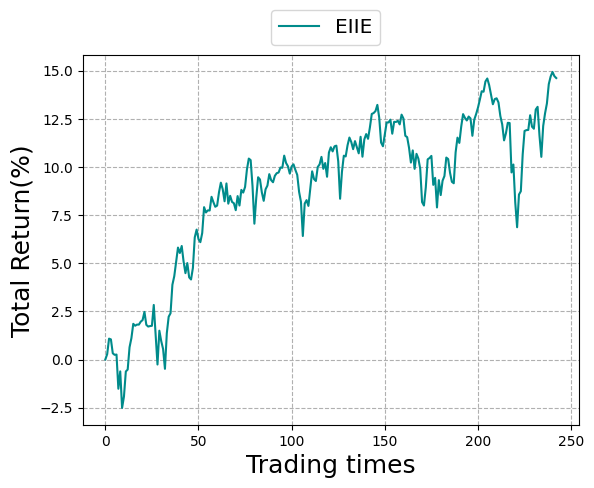

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline



def plot(df,alg,color='darkcyan',):
    x = range(len(df))
    y=(df["total assets"].values-df["total assets"].values[0])/df["total assets"].values[0]
    plt.plot(x, y*100, color, label=alg)
    plt.xlabel('Trading times',size=18)
    plt.ylabel('Total Return(%)',size=18)
    plt.grid(ls='--')
    plt.legend(loc='upper center', fancybox=True, ncol=1, fontsize='x-large',bbox_to_anchor=(0.49, 1.15,0,0))
    plt.savefig("fig.pdf")
    plt.show()
plot(trainer.test_environment.save_asset_memory(),alg="EIIE")
plt.show()

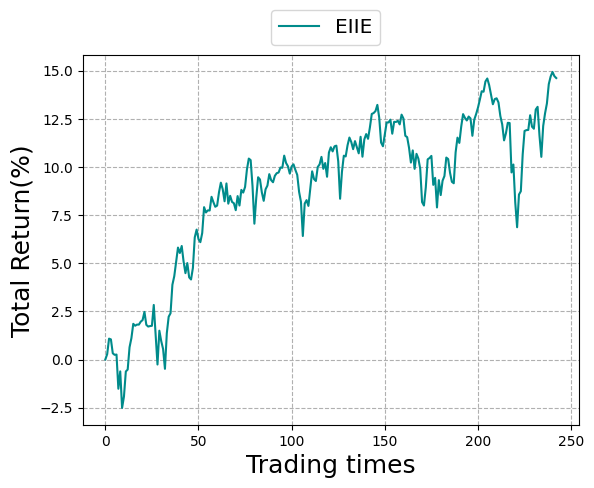

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
plot(trainer.test_environment.save_asset_memory(),alg="EIIE")


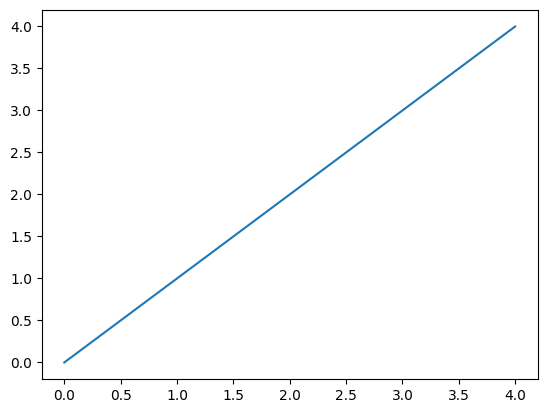

In [36]:
plt.plot(range(5),range(5))